In [17]:
# LSTM 모델 만들기!  아직 수정 중!!! 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from pyproj import Transformer

import binascii
from shapely import wkb
import pyproj

def convert_wkb_to_coordinates(wkb_string):
    
    # 0단계 :Check if the value is a float
    if isinstance(wkb_string, float):
        return None, None
    
    # 1단계: 16진수 문자열을 이진 형식으로 디코딩
    binary_string = binascii.unhexlify(wkb_string)

    # 2단계: 이진 형식 파싱 
    geometry = wkb.loads(binary_string)

    # 3단계: 좌표를 위도와 경도로 변환
    if geometry and hasattr(geometry, 'wkt'):
        # Well-Known Text (WKT) 형식으로 변환
        wkt = geometry.wkt

        # 좌표 시스템 변환 정의
        #!crs_from = pyproj.Proj(init='epsg:3857')
        #!crs_to = pyproj.Proj(init='epsg:4326')
        transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326")
        transformer.transform(12, 12)

        # 좌표 변환 수행
        #! transformed = pyproj.transform(crs_from, crs_to, geometry.x, geometry.y)
        transformed = Transformer.transform(transformer,geometry.x, geometry.y)

        # 위도와 경도 추출
        latitude, longitude = transformed[0], transformed[1]
        
        return latitude, longitude
    else:
        return None, None
    
# CSV 파일에서 데이터 로드
data = pd.read_csv('D:/장우영/LOCALSEARCH/Ship_DA/DA/data/FAmerge_20230607_1147142.csv', encoding='ANSI')

# 특정 칼럼의 조건에 따라 데이터 필터링
filtered_data = data[data['sog'] > 3]  # 특정 칼럼과 조건을 적절히 수정해야 합니다

data= filtered_data

# 좌표 변환 적용 및 데이터프레임 업데이트
data[['latitude', 'longitude']] = data['geom'].apply(convert_wkb_to_coordinates).apply(pd.Series)

#print(data[['latitude', 'longitude']])

# "insert_time"을 숫자로 변환
data['year'] = pd.to_datetime(data['insert_time']).dt.year
data['month'] = pd.to_datetime(data['insert_time']).dt.month
data['day'] = pd.to_datetime(data['insert_time']).dt.day
data['hour'] = pd.to_datetime(data['insert_time']).dt.hour
data['minute'] = pd.to_datetime(data['insert_time']).dt.minute
data['second'] = pd.to_datetime(data['insert_time']).dt.minute


# 특성과 타겟 변수 선택
X = data[["mmsi", "ship_type", "latitude", "longitude", "cog", "sog", "year", "month", "day", "hour", "minute", "second", "풍향", "유향", "기온", "수온", "풍속", "유속", "기압", "습도"]]
X['minute'] = pd.to_datetime(data['insert_time']).dt.minute + 1
y = data[["latitude", "longitude","cog", "sog"]]

print(X)

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MinMaxScaler를 사용하여 입력 특성 스케일 조정
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LSTM에 맞게 입력 데이터 형태 변환
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# LSTM 모델 생성
model_LSTRM = Sequential()
model_LSTRM.add(LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_LSTRM.add(Dense(4))  # 출력층, 4개의 뉴런 (latitude, longitude, sog, cog)

# 모델 컴파일
model_LSTRM.compile(loss='mse', optimizer='adam')

# 조기 종료를 위한 EarlyStopping 정의
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# LSTM 모델 훈련
history = model_LSTRM.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_data=(X_test_reshaped, y_test), callbacks=[early_stopping])

# LSTM 모델을 사용하여 예측 수행
y_pred = model_LSTRM.predict(X_test_reshaped)

# Convert predictions to a list
y_pred_list = y_pred.tolist()

# 평균 제곱 오차 계산
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# y_test(실제 값)와 y_pred(예측 값) 사이의 R-제곱 값을 계산
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)


# Create the response JSON
response = {
    "latitude": y_pred_list[0][0],
    "longitude": y_pred_list[0][1],
    "predicted_cog": y_pred_list[0][2],
    "predicted_sog": y_pred_list[0][3]
    
}


C:\Users\SW\AppData\Local\Temp\ipykernel_13872\2303957601.py:51: DtypeWarning: Columns (1,3,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('D:/장우영/LOCALSEARCH/Ship_DA/DA/data/FAmerge_20230607_1147142.csv', encoding='ANSI')
C:\Users\SW\AppData\Local\Temp\ipykernel_13872\2303957601.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['minute'] = pd.to_datetime(data['insert_time']).dt.minute + 1


               mmsi  ship_type   latitude   longitude    cog   sog  year   
0       440051540.0        0.0  35.039909  129.062547  329.2   5.7  2023  \
5       538010219.0        0.0  34.882612  129.060553  212.2  16.1  2023   
17      440051540.0        0.0  35.039909  129.062547  329.2   5.7  2023   
19      440102990.0        0.0  35.099860  129.041436   42.6   8.8  2023   
20      440048210.0       80.0  35.064618  129.110167   31.6   9.6  2023   
...             ...        ...        ...         ...    ...   ...   ...   
329822  613744000.0       70.0  35.036195  129.038113    3.0   5.5  2023   
329826  431602232.0       60.0  35.012839  129.243647  307.0  15.9  2023   
329833  440700770.0       30.0  34.121082  128.358546  258.0   7.1  2023   
329835  440047230.0       89.0  34.946146  129.160302  225.0   8.1  2023   
329836  440107000.0       80.0  35.047874  129.143773  137.4  11.8  2023   

        month  day  hour  minute  second     풍향     유향    기온    수온    풍속   유속   
0     

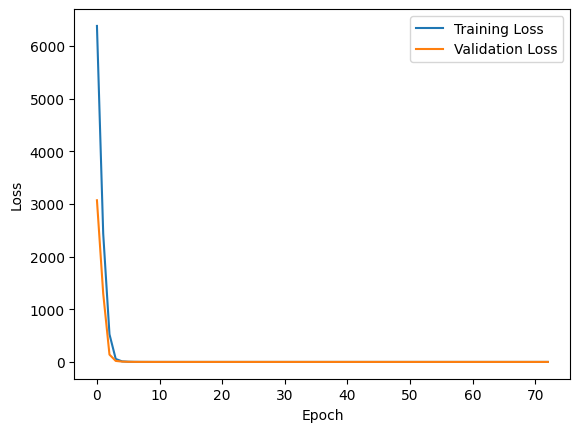

In [18]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


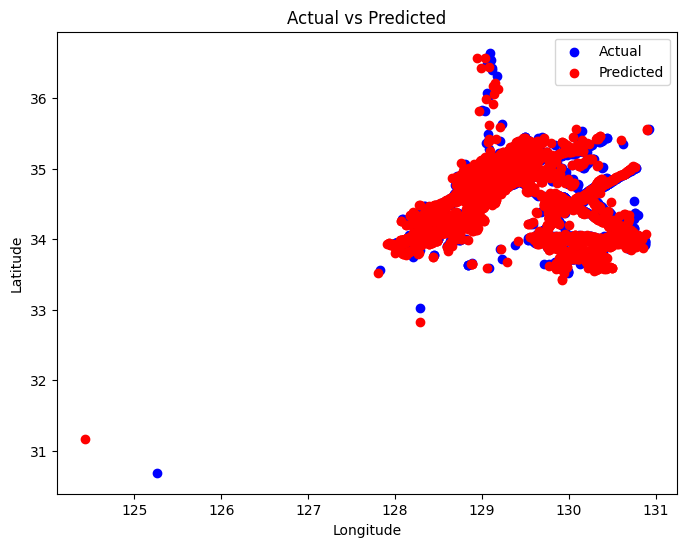

In [21]:
import matplotlib.pyplot as plt

# Extract latitude and longitude values from y_test and y_pred
y_test_lat = y_test['latitude']
y_test_lon = y_test['longitude']
y_pred_lat = y_pred[:, 0]  # Predicted latitude values
y_pred_lon = y_pred[:, 1]  # Predicted longitude values

# Create scatter plot for latitude
plt.figure(figsize=(8, 6))
plt.scatter(y_test_lon, y_test_lat, color='blue', label='Actual')
plt.scatter(y_pred_lon, y_pred_lat, color='red', label='Predicted')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()



#### training loss가 꾸준히 감소하고 validation loss도 함께 감소
#### 속도와 방향은 워낙 다양한 값이 존재하여 그래프로 시각화하기 부적절

In [ ]:
# 위의 코드는 LSTM(Long Short-Term Memory) 모델을 사용하여 데이터를 훈련하고 예측하는 예제입니다. 
# 아래는 코드의 주요 내용을 요약한 것입니다.

# 필요한 라이브러리를 import합니다.
# 좌표 변환 함수를 정의합니다.
# CSV 파일에서 데이터를 로드합니다.
# 좌표 변환을 적용하고 "insert_time"을 숫자로 변환합니다.
# 특성과 타겟 변수를 선택합니다.
# 데이터를 훈련 세트와 테스트 세트로 분할합니다.
# 입력 특성을 스케일 조정합니다.
# LSTM에 입력하기 위해 데이터의 형태를 변환합니다.
# LSTM 모델을 생성합니다.
# 모델을 컴파일합니다.
# 조기 종료를 위한 EarlyStopping을 정의합니다.
# LSTM 모델을 훈련합니다.
# 모델을 사용하여 예측을 수행합니다.
# 평균 제곱 오차를 계산합니다.
# 위의 코드를 실행하면 LSTM 모델을 사용하여 데이터를 훈련하고 예측하며, 평균 제곱 오차를 출력합니다.

#해당 모델은 주어진 특성(feature)들을 사용하여 주어진 시간에 대한
#배의 위도(latitude), 경도(longitude), Course Over Ground (COG), Speed Over Ground (SOG)를 예측

In [14]:
import pickle

# 모델 저장
with open('linear_regression_model_Lstm.pkl', 'wb') as file:
    pickle.dump(model_LSTRM, file)
    

# 모델을 불러오기 위해 pickle 파일을 엽니다.
model = pickle.load(open('linear_regression_model_Lstm.pkl', 'rb'))

In [15]:
import pickle

# Save the scaler object
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Load the scaler object
loaded_scaler = pickle.load(open('scaler.pkl', 'rb'))